<a href="https://colab.research.google.com/github/jsemer/fibertree-graphs/blob/main/spmv_and_gunrock_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
__author__ = "Toluwanimi Odemuyiwa"
__copyright__ = ""
__date__ = "July 2023"
__credits__ = ["Toluwanimi Odemuyiwa", "Joel emer"]
__license__ = ""
__version__ = "1.0.0"
__maintainer__ = ["Toluwanimi Odemuyiwa", "Joel Emer"]
__email__ = "todemuyiwa@ucdavis.edu"
__status__ = "Production"

# Goal
The goal of this notebook is to determine how we can express tiling + the load balancing primitives in [loops](https://github.com/gunrock/loops) using HiFiber, then determining if we can use the current TeAAL specifications to express this combination of tiling and load balancing. We will use SpMV as the running example for now.

## 1. Set up HiFiber

In [3]:
# Begin - startup boilerplate code

import pkgutil

if 'fibertree_bootstrap' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python3 -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet

# End - startup boilerplate code


from fibertree_bootstrap import *
fibertree_bootstrap(style="tree", animation='movie', logger=False)


  Preparing metadata (setup.py) ... done
Running bootstrap
The fibertree module is not available. Installing...


interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

## 2. Setup our Tensors
1. Inputs:
  - A sparse matrix A
    - Ranks: M, K
  - A vector B
    - Ranks: K
2. Outputs:
  - A sparse output Z
    - Ranks: M

We will use `0.0` as the "empty" value for all of our tensors.


In [4]:
M = 15
N = 15
K = 15
density = [0.5, 0.8]
seed = 10

def set_params(rank_M, rank_N, rank_K, tensor_density, rand_seed):
    global M
    global N
    global K
    global density
    global seed

    M = rank_M
    N = rank_N
    K = rank_K

    if tensor_density == 'sparse':
        density = [0.9, 0.8]
    elif tensor_density == 'sparser':
        density = [0.9, 0.4]
    else:
        density = [1.0, 1.0]

    seed = rand_seed
    this_density = density
interactive(set_params,
            rank_M=widgets.IntSlider(min=2, max=25, step=1, value=M),
            rank_N=widgets.IntSlider(min=2, max=25, step=1, value=N),
            rank_K=widgets.IntSlider(min=2, max=25, step=1, value=K),
            #this_density=widgets.IntSlider(min=0, max=100, step=1, value=density),
            tensor_density=['sparse', 'sparser', 'dense'],
            rand_seed=widgets.IntSlider(min=0, max=100, step=1, value=seed))

interactive(children=(IntSlider(value=15, description='rank_M', max=25, min=2), IntSlider(value=15, descriptio…

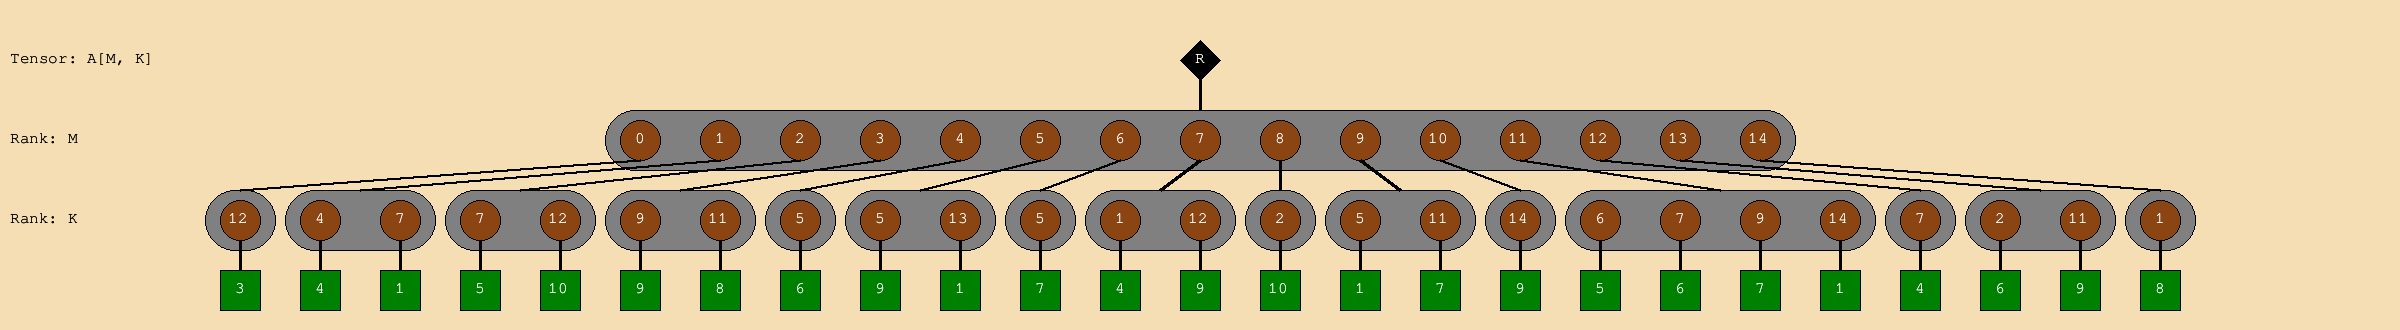

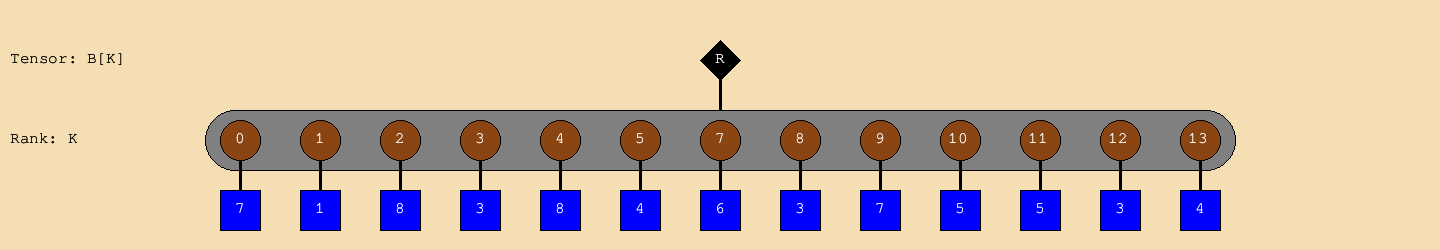

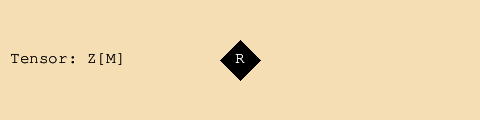

In [5]:
# Our sparse input matrix
A = Tensor.fromRandom(rank_ids=["M", "K"], shape=[M, K],
                      density=0.15, seed=seed, name="A",
                      color='green', default=0.0)
displayTensor(A)

# Our vector
B = Tensor.fromRandom(rank_ids=["K"], shape=[K], density=.95, seed=seed, name="B", color='blue', default=0.0)
displayTensor(B)

# Our output
def reset_Z(M, rank_ids):
  Z = Tensor(name="Z", rank_ids=rank_ids, shape=[M], color="red", default=0.0)
  return Z

Z = reset_Z(M, ["M"])
displayTensor(Z)

***
***
## 3. Thread-Mapped Strategy

**GPU terminology:**
- In thread-mapped, we assign each *thread* a "tile" of work. We assign `grid_size` blocks to the GPU, and `block_size` threads per block.
- In space-time, `block_size` threads run in parallel within an SM. If `grid_size` is less than the `maxBlocksPerMultiProcessor` * `multiProcessorCount`, then `grid_size` blocks also run in parallel. Otherwise a portion of `grid_size` blocks run sequentially.

**Fibertree/Einsum terminology:**


#### Let's create our schedule tensor to understand the overall \# of tasks we have. We define a task as a unit of compute.

Some Notes:
- I want to assert that our schedule tensor should always consist of the same ranks as our iteration space. Do we agree with this?
  - Suggestion:
    - einsum + mapping directives --> a new transformed iteration space that then has a 1-to-1 relationship to our schedule tensor. And a concordant traversal of our schedule tensor corresponds to an execution of the Einsum + mapping.
- Our schedule tensor actually consists of the operations we do on the *coordinates* of the iteration space (i.e. the output of our merge operators)

- Schedule tensor is a tensor that has points for every effectual computation in the iteration space of an Einsum after algebraic manipulations and mapping. It may be created dynamically (e.g.: reflecting the consequences of intersection) OR statically (e.g.: with calculations that reflect the consequences of intersection statically -- such as symbolic execution of SpGEMM before actual computation).
  - Note that the schedule tensor may never be instantiated
  - An execution of the Einsum will correspond to a concordant traversal of the schedule tensor. Note that the schedule tensor is an abstract representation of the schedule and so may never be instantiated.
  - We note that mapping manipulations will often have a one-to-one correspondence with transformations on the schedule tensor. For example, a loop order change in the mapping will result in a rank swizzle of the schedule tensor (note this tells nothing about if the data tensors were rank-swizzled).
  - we may want to use monolithic vs incremental rather than static vs dynamic.
  - Note that the schedule tensors can be data-independent or data-dependent. The data dependency results from the merge operators that we express in the Einsums (the map, reduce, populate operators).
  - sometimes the schedule tensor will contain tasks that don't result in effectual computation (e.g. -- this may be a bad example, come back to this: leader-follower in sparse-sparse computations where the leader contains a coordinate that does not exist in the follower). We can call this a noisy schedule tensor (this is still in flux, but we need a name for a schedule tensor that includes points that result in ineffectual computation).

HiFiber Bugs:
- There's a bug! If I say `ST.setDefault(None)`, HiFiber fails on the "Payload.is_payload` assertion during a popualte.


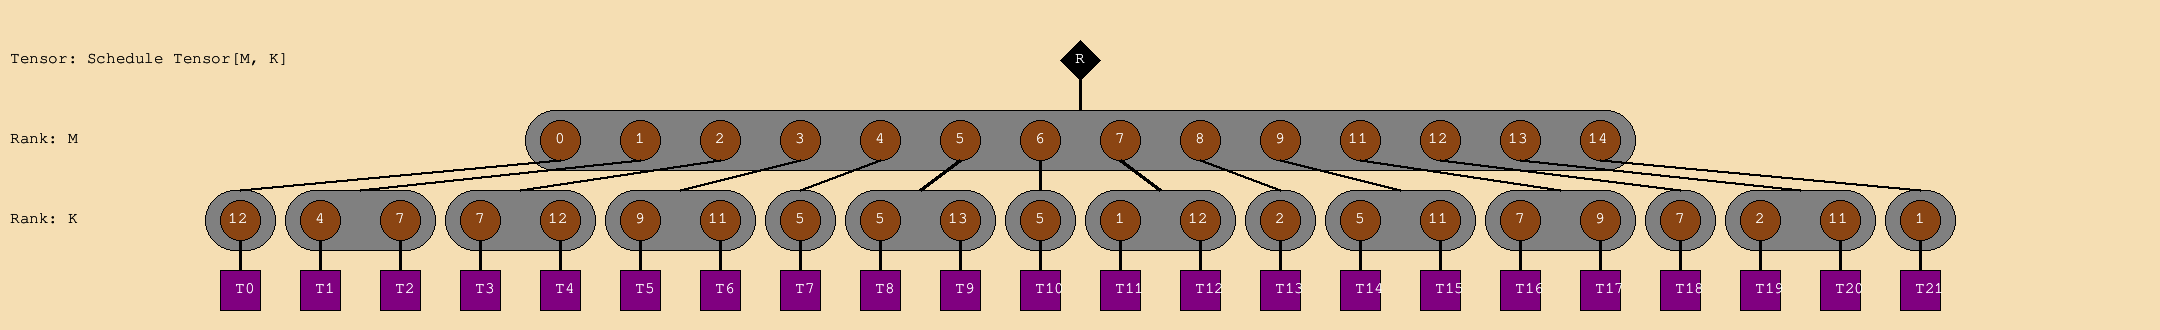

We have 22 tasks.


In [6]:
# Visualize the tasks at each point in our M by N iteration space
# Our schedule tensor should always consist of the same ranks as our iteration space?
ST = Tensor(name="Schedule Tensor", rank_ids=["M","K"], shape=A.getShape())
ST.setColor("purple")
#ST.setDefault(None)

a_m = A.getRoot()
b_k = B.getRoot()
st_m = ST.getRoot()

task_id = 0
# What is the task we have at each point in the iteration space?

# We populate the output at each `m` point in the iteration space
for m, (st_k, a_k) in st_m << a_m:
  #We perform an intersection at each `k` point in the iteration space
  for k, (st_ref, (a_val, b_val)) in st_k << (a_k & b_k):
    #This is a task!
    st_ref <<= f"T{task_id}"
    task_id +=1
total_tasks = task_id
displayTensor(ST)
print(f"We have {task_id} tasks.")
#How do I show it uncompressed?
#displayTensor(ST)

Ok, now in Gunrock Loops, an "atom" is the equivalent of what we just called a "task." A "work tile" is some sort of grouping of those tasks. Let's create "work tiles" per $m$ coordinate. That is, we're going to split on $M$ such that tasks with the same $m$ coordinate are in the same work tile.

Note that once we do this, we are also projecting this partitioning on the schedule tensor back into the data space. That is, $A$ and $Z$ are now partitioned on $M$, and $B$ is not partitioned at all.

Let's apply the "thread-mapped" schedule to each work tile. We'll ignore `block_size` and `grid_size` for now.

Our split schedule Tensor


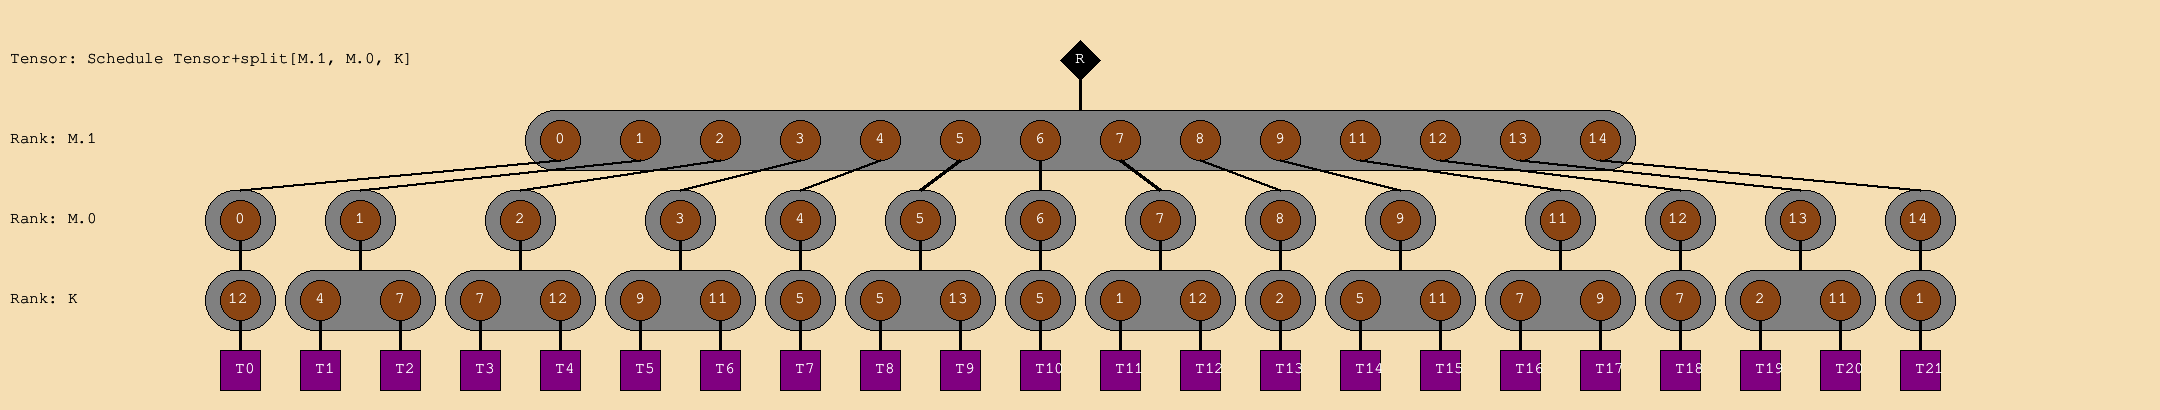

In [7]:
num_pes = total_tasks
M0 = 1

ST_split_on_m = ST.splitUniform(M0)
print("Our split schedule Tensor")
displayTensor(ST_split_on_m)
st_m1 = ST_split_on_m.getRoot()
a_m = A.getRoot()
b_k = B.getRoot()
z_m = Z.getRoot()

canvas = createCanvas(ST_split_on_m, A, B, Z)

# Get my task
for pe, (m1, st_m0) in enumerate(st_m1):
  for pos_m0, (m0, st_k) in enumerate(st_m0):
    for pos_k, (k, task) in enumerate(st_k):
      # Project to the data space
      m = m0+M0*m1
      a_val = a_m.getPayload(m0+M0*m1, k)
      b_val = b_k.getPayload(k)
      z_ref = z_m.getPayload(m0+M0*m1)
      z_ref += a_val * b_val
      canvas.addActivity((m1, m0, k), (m, k), (k,), (m,),
                        spacetime=(pe, (pos_m0, pos_k))
                        )

displayCanvas(canvas)

Note that the above isn't quite accurate because in a real loops implementation, each non-zero in a row of A would correspond to a task since we use that as our leader during intersection. That is, the intersection step is also part of the tasks that occur -- not all tasks correspond to valid compute!

Let's quickly readjust our schedule tensor and thread-mapped schedule to account for this.

Thoughts on einsum backend:
1. How can we represent two-way intersection in Gunrock/Loops? Currently, loops only supports leader-follower intersection.

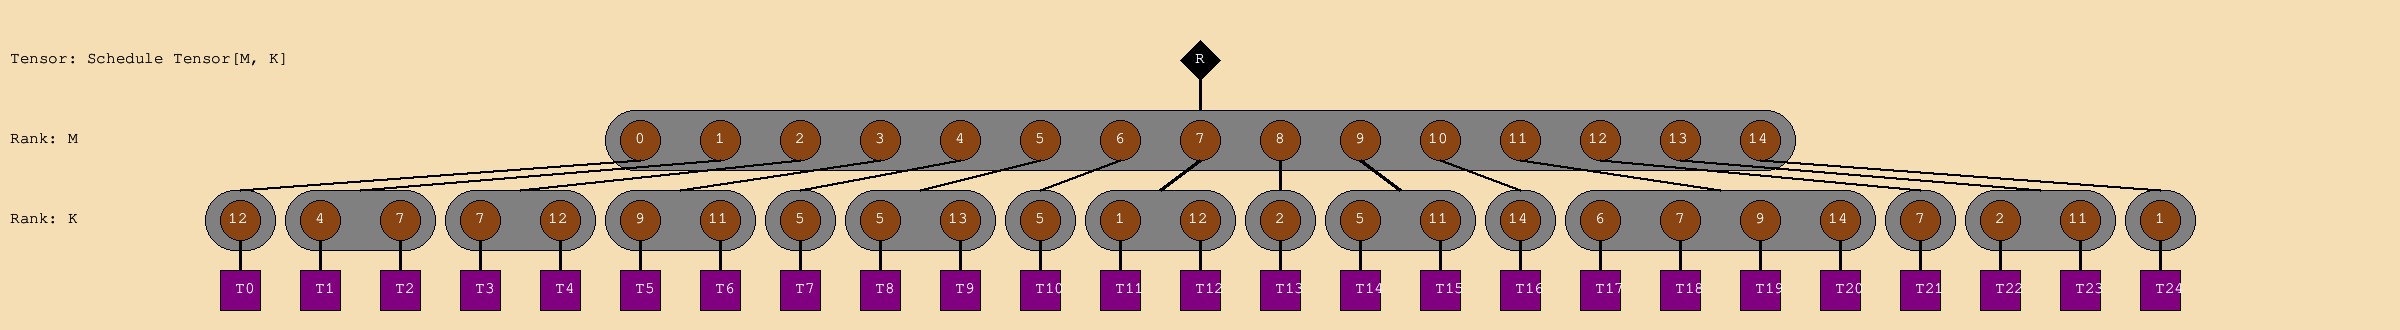

We have 25 tasks.


In [8]:
# Visualize the tasks at each point in our M by N iteration space
# Our schedule tensor should always consist of the same ranks as our iteration space?
ST = Tensor(name="Schedule Tensor", rank_ids=["M","K"], shape=A.getShape())
ST.setColor("purple")
#ST.setDefault(None)

a_m = A.getRoot()
b_k = B.getRoot()
st_m = ST.getRoot()

task_id = 0
# What is the task we have at each point in the iteration space?

# We populate the output at each `m` point in the iteration space
for m, (st_k, a_k) in st_m << a_m:
  #We perform an intersection at each `k` point in the iteration space
  #Leader on A!
  for k, (st_ref, (a_val)) in st_k << (a_k):
    b_val = b_k.getPayload(k)
    #This is a task!
    st_ref <<= f"T{task_id}"
    task_id +=1
total_tasks = task_id
displayTensor(ST)
print(f"We have {task_id} tasks.")




Our split schedule Tensor


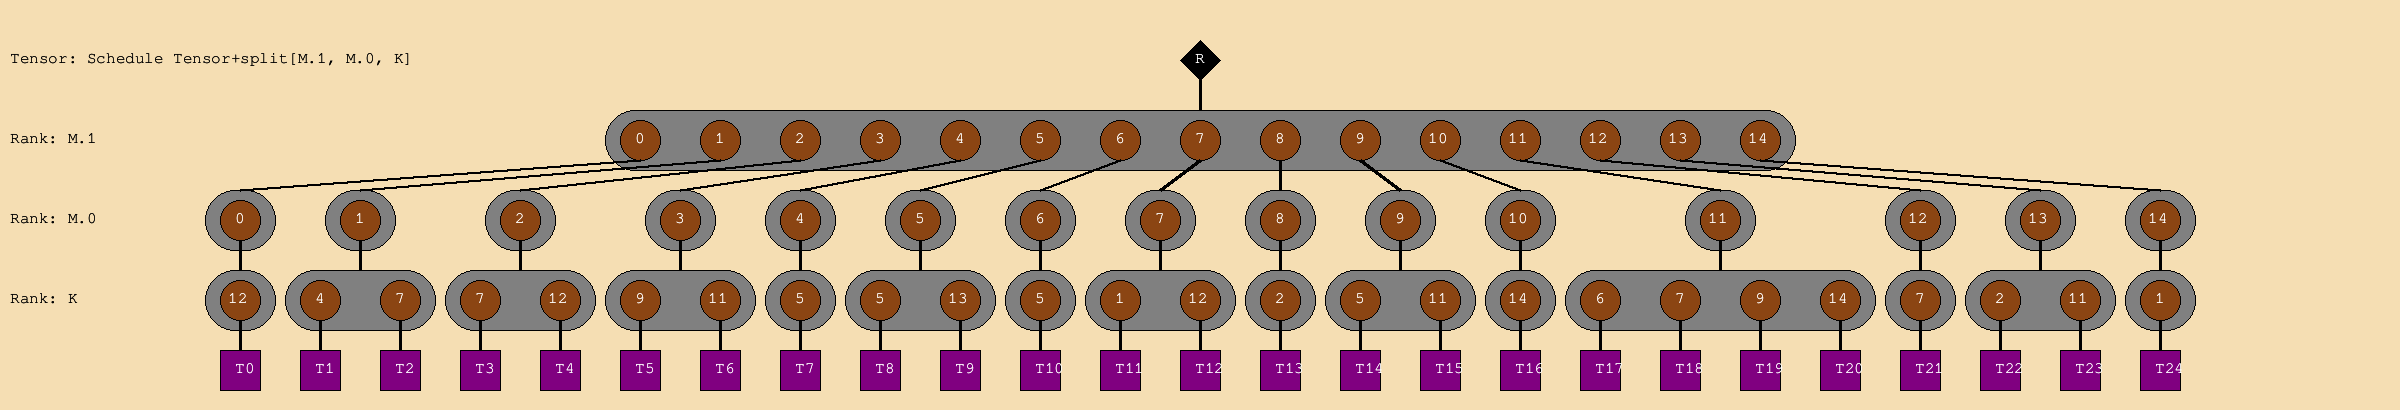

KeyboardInterrupt: ignored

In [9]:
num_pes = total_tasks
M0 = 1

ST_split_on_m = ST.splitUniform(M0)
print("Our split schedule Tensor")
displayTensor(ST_split_on_m)

Z = reset_Z(M, ["M"])
st_m1 = ST_split_on_m.getRoot()
a_m = A.getRoot()
b_k = B.getRoot()
z_m = Z.getRoot()

canvas = createCanvas(ST_split_on_m, A, B, Z)

# Get my task
for pe, (m1, st_m0) in enumerate(st_m1):
  for pos_m0, (m0, st_k) in enumerate(st_m0):
    for pos_k, (k, task) in enumerate(st_k):
      # Project to the data space
      m = m0+M0*m1
      a_val = a_m.getPayload(m0+M0*m1, k)
      b_val = b_k.getPayload(k)
      z_ref = z_m.getPayload(m0+M0*m1)
      z_ref += a_val * b_val
      canvas.addActivity((m1, m0, k), (m, k), (k,), (m,),
                        spacetime=(pe, (pos_m0, pos_k))
                        )

displayCanvas(canvas)

Great! Now let's think about the GPU mappings. In loops, we have two parameters:
  - grid_size --> \# of blocks per grid
  - block_size --> \# of threads per block
  - there's also an implicit parameter "# grids" which is based on how many grids we have. Grids are scheduled sequentially.

Let's assume the following:
1. block_size --> T0 -->  threads per block --> (T-1)/(T1 + 1)
2. grid_size --> T1 --> blocks per GPU

- here, $T$ is the total number of tasks we have?
- we're assuming we want the # of grids parameter to be equal to 1, so we fix T1 (our grid_size) and calculate block_size from that. Note that is equivalent to doing `nway_shape(grid_size)` in the TeAAL mapping specs.
- Let's assume we have 2 SMs that allow 2 blocks each, so we can have 4 blocks max on the GPU. That is, T1 = 2

Note that in the visualization below, it is very easy to see the load imbalance within a block and across blocks!

We have T: 25 T1: 4, T0: 7.0, M0: 1


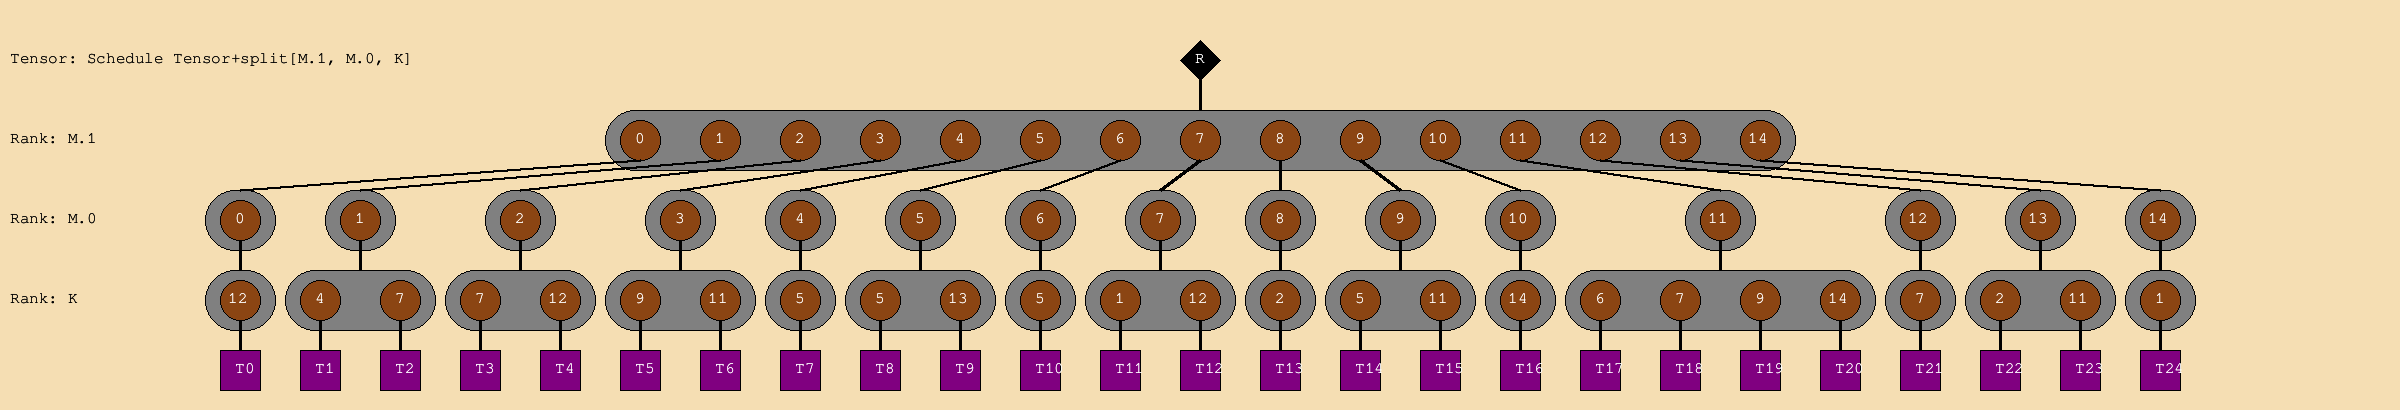

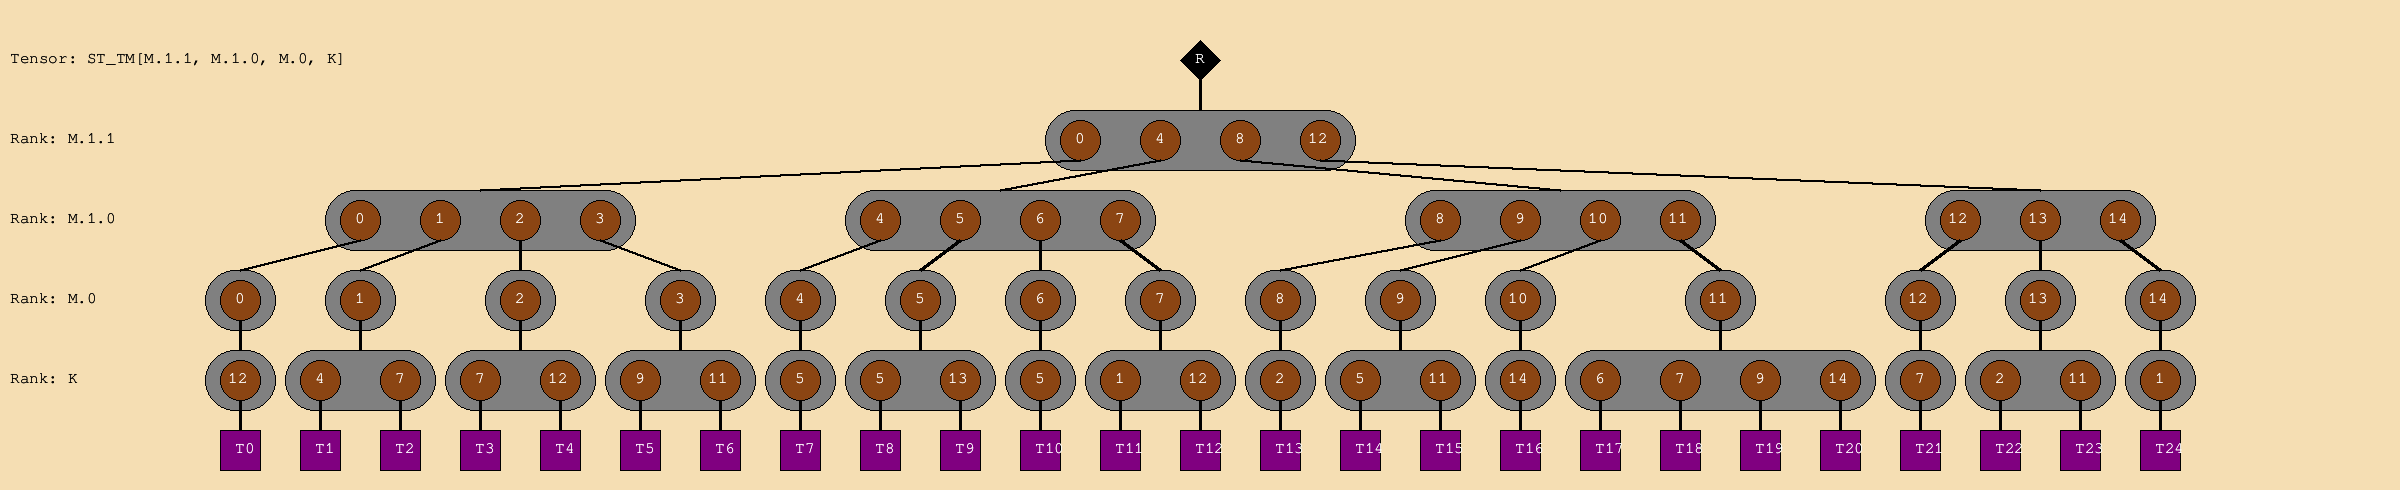

Our split schedule Tensor
	t1 --> our blockId
	t0 --> our global threadID = blockID*T0+local thread ID


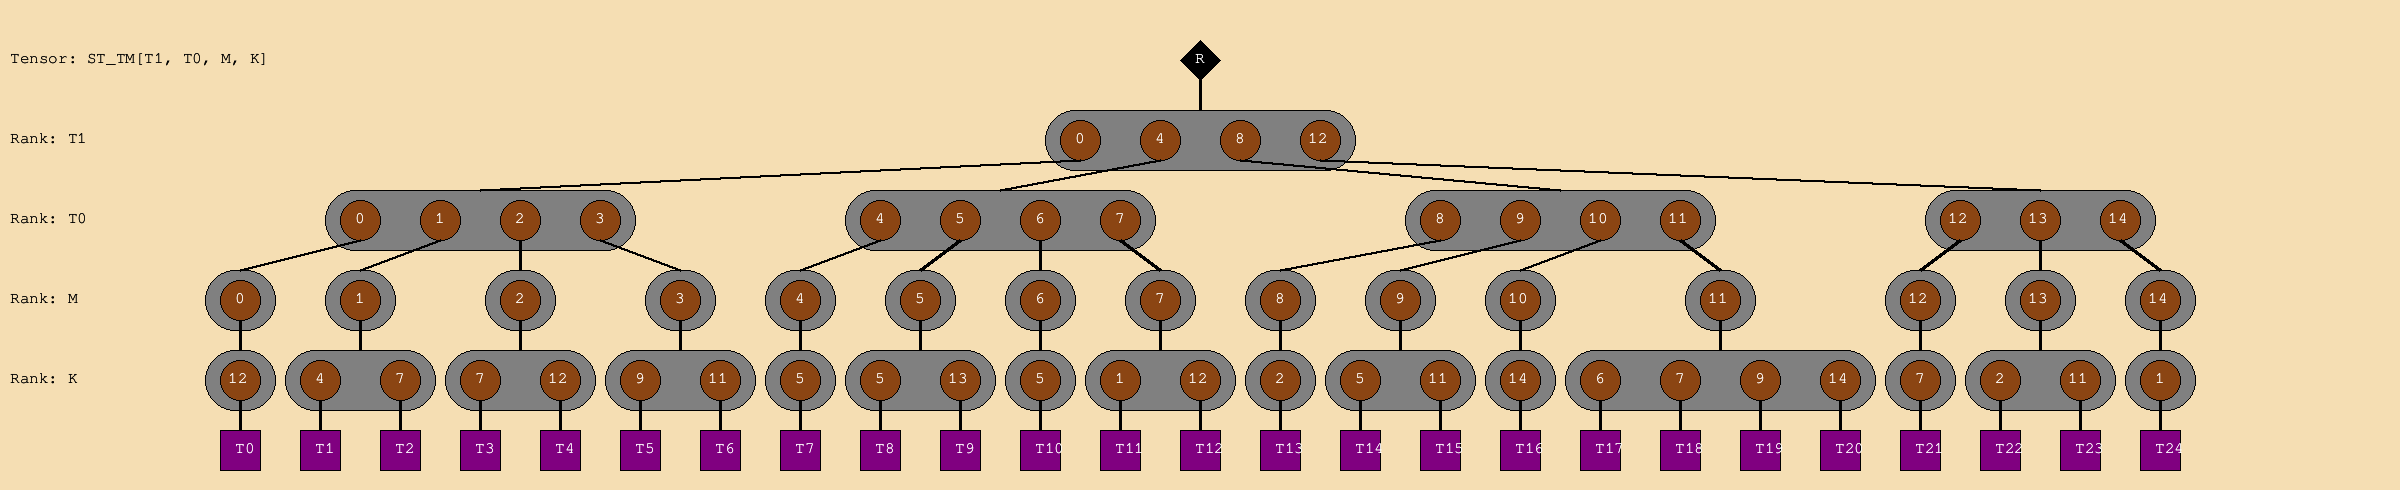

In [10]:
num_pes = total_tasks
M0 = 1
T = total_tasks
T1 = 4
T0 = (T+T1-1)/(T1)

print(f"We have T: {T} T1: {T1}, T0: {T0}, M0: {M0}")
#ST_thread_mapped = ST_split_on_m.swizzleRanks([ "M.0", "K", "M.1"])
#displayTensor(ST_thread_mapped)

ST_thread_mapped= ST_split_on_m.splitUniform(T1, depth=0)
ST_thread_mapped.setName("ST_TM")
displayTensor(ST_split_on_m)
displayTensor(ST_thread_mapped)

ST_thread_mapped.setRankIds(rank_ids=["T1", "T0", "M", "K"])
print("Our split schedule Tensor")
print("\tt1 --> our blockId")
print("\tt0 --> our global threadID = blockID*T0+local thread ID")
displayTensor(ST_thread_mapped)

Z = reset_Z(M, ["M"])
st_b1 = ST_thread_mapped.getRoot()

# Technically we also split the data, but we'll ignore that...
a_m = A.getRoot()
b_k = B.getRoot()
z_m = Z.getRoot()

canvas = createCanvas(ST_thread_mapped, A, B, Z)

# Get my task
# parallel for on the blocks
for block, (b1, st_b0) in enumerate(st_b1):
  # parallel for within a block (threads run in parallel!)
  for thread, (b0, st_m) in enumerate(st_b0):
      for tile_m, (m, st_k) in enumerate(st_m):
        for task_id, (k, task) in enumerate(st_k):
          # Project to the data space
          a_val = a_m.getPayload(m, k)
          b_val = b_k.getPayload(k)
          z_ref = z_m.getPayload(m)
          z_ref += a_val * b_val
          canvas.addActivity((b1, b0, m, k), (m, k), (k,), (m,),
                            spacetime=((block, thread), (tile_m, task_id))
                            )

displayCanvas(canvas)

The above example worked nicely because we partitioned such that a thread works on a single row. What if we partitioned such that a thread works on an MxK block instead?

Lets partition in coordinate space such that M0=3 and K0 = 2.

In "Gunrock Loops" terms, our work atom is still a single task in the default schedule tensor. (<mark>Do we like this term of "default schedule tensor?"</mark>). Our work *tile* is now a single M0xK0 tile. Our work set is still the entire schedule tensor.

 We need to apply this transformation to our schedule tensor. Additionally, let's just assume a flat partitioning where all threads run in parallel on their work tile (i.e. we're ignoring the grids and blocks):

Our split schedule Tensor ['M.1', 'M.0', 'K']


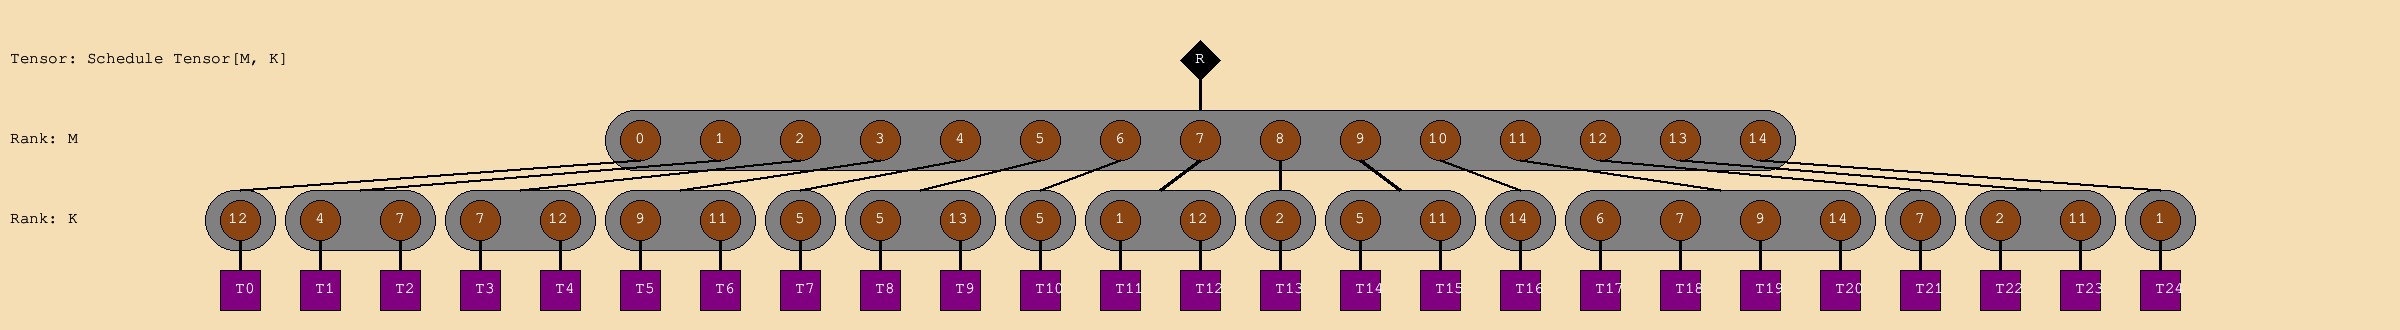

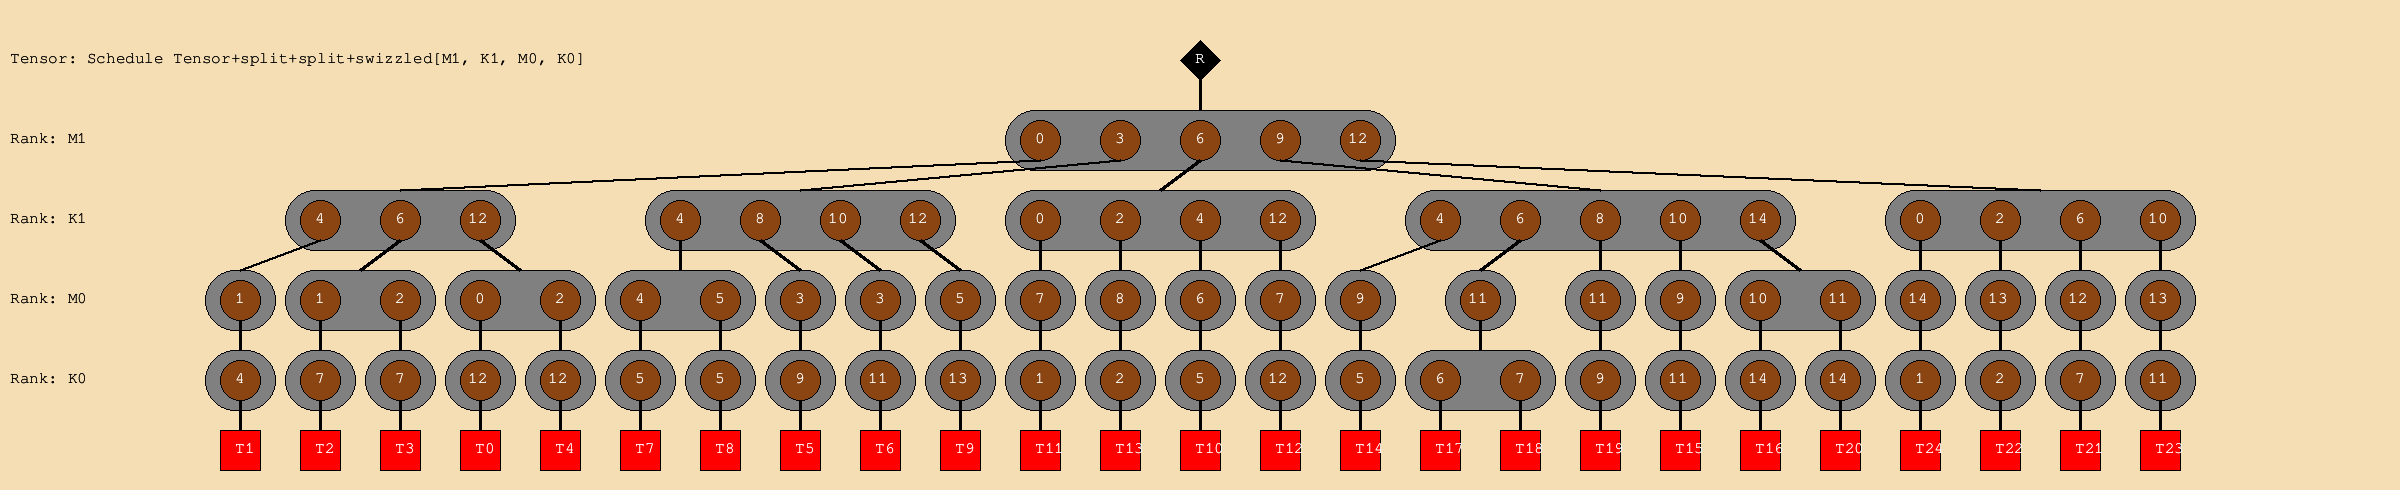

In [20]:
num_pes = total_tasks
M0 = 3
K0 = 2

ST_split_on_mk = ST.splitUniform(M0)
print("Our split schedule Tensor", ST_split_on_mk.getRankIds())
ST_split_on_mk = ST_split_on_mk.splitUniform(K0, rankid='K', relativeCoords=False)
ST_split_on_mk.setRankIds(["M1", "M0", "K1", "K0"])
# We want each PE to work on a  single M1, K1 tile
ST_split_on_mk = ST_split_on_mk.swizzleRanks(["M1", "K1",  "M0", "K0"])
displayTensor(ST)
displayTensor(ST_split_on_mk)

st_m1 = ST_split_on_mk.getRoot()
Z = reset_Z(M, ["M"])
a_m = A.getRoot() #technically this was split the same way as the schedule tensor
b_k = B.getRoot()
z_m = Z.getRoot()

canvas = createCanvas(ST_split_on_mk, A, B, Z)

# Get my task
for pos_m1, (m1, st_k1) in enumerate(st_m1):
  for pos_k1, (k1, st_m0) in enumerate(st_k1):
    for pos_m0, (m0, st_k0) in enumerate(st_m0):
      for pos_k0, (k0, task) in enumerate(st_k0):
        # Project to the data space
        m = m0+M0*m1
        k = k0+K0*k1
        a_val = a_m.getPayload(m, k)
        b_val = b_k.getPayload(k)
        z_ref = z_m.getPayload(m)
        z_ref += a_val * b_val
        canvas.addActivity((m1, m0, k1, k0), (m, k), (k,), (m,),
                          spacetime=((pos_m1, pos_k1), (pos_m0, pos_k0))
                          )

displayCanvas(canvas)
